# 2012 Federal Election Commission Database

*The US Federal Election Commission (FEC) publishes data on contributions to political campaigns. This includes contributor names, occupation and employer, address, and contribution amount*

### Imports

In [1]:
import json
from collections import defaultdict, Counter
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
fec = pd.read_csv("datasets/fec/P00000001-ALL.csv", low_memory=False)

fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

In [3]:
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                        50.0
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [4]:
unique_cands = fec["cand_nm"].unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [5]:
parties = {"Bachmann, Michelle": "Republican",
           "Cain, Herman": "Republican",
           "Gingrich, Newt": "Republican",
           "Huntsman, Jon": "Republican",
           "Johnson, Gary Earl": "Republican",
           "McCotter, Thaddeus G": "Republican",
           "Obama, Barack": "Democrat",
           "Paul, Ron": "Republican",
           "Pawlenty, Timothy": "Republican",
           "Perry, Rick": "Republican",
           "Roemer, Charles E. 'Buddy' III": "Republican",
           "Romney, Mitt": "Republican",
           "Santorum, Rick": "Republican"}

In [6]:
fec["cand_nm"][123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [7]:
fec["cand_nm"][123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [9]:
# Add it as a column
fec["party"] = fec["cand_nm"].map(parties)

fec["party"].value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

*A couple of data preparation points. First, this data includes both contributions and refunds (negative contribution amount)*

In [10]:
(fec["contb_receipt_amt"] > 0).value_counts()

contb_receipt_amt
True     991475
False     10256
Name: count, dtype: int64

In [22]:
# To simplify the analysis, I’ll restrict the dataset to positive contributions:

fec = fec[fec["contb_receipt_amt"] > 0]

# Since Barack Obama and Mitt Romney were the main two candidates, I’ll also prepare a subset that just has contributions to their campaigns:

fec_mrbo = fec[fec["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"])]

fec_mrbo

,cmte_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_employer,contbr_occupation,contb_receipt_amt,contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,party
411,C00431171,P80003353,"Romney, Mitt","ELDERBAUM, WILLIAM",DPO,AA,340230183,US GOVERNMENT,FOREIGN SERVICE OFFICER,25.0,01-FEB-12,NaN,NaN,NaN,SA17A,780124,Republican
412,C00431171,P80003353,"Romney, Mitt","ELDERBAUM, WILLIAM",DPO,AA,340230183,US GOVERNMENT,FOREIGN SERVICE OFFICER,110.0,01-FEB-12,NaN,NaN,NaN,SA17A,780124,Republican
413,C00431171,P80003353,"Romney, Mitt","CARLSEN, RICHARD",APO,AE,091280020,DEFENSE INTELLIGENCE AGENCY,INTELLIGENCE ANALYST,250.0,13-APR-12,NaN,NaN,NaN,SA17A,785689,Republican
414,C00431171,P80003353,"Romney, Mitt","DELUCA, PIERRE",APO,AE,091280005,CISCO,ENGINEER,30.0,21-AUG-11,NaN,NaN,NaN,SA17A,760261,Republican
415,C00431171,P80003353,"Romney, Mitt","SARGENT, MICHAEL",APO,AE,090120092,RAYTHEON TECHNICAL SERVICES CORP,COMPUTER SYSTEMS ENGINEER,100.0,07-MAR-12,NaN,NaN,NaN,SA17A,780128,Republican
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701381,C00431445,P80003338,"Obama, Barack","MOUNTS, ROBERT",APO,ZZ,962043077,HQ USFK (FKDC-SA),GS-15 INTERNATIONAL RELATIONS OFFICER,25.0,26-FEB-12,NaN,NaN,NaN,SA17A,787803,Democrat
701382,C00431445,P80003338,"Obama, Barack","TAITANO, TYRONE",HAGATNA,ZZ,969323373,NOT EMPLOYED,RETIRED,250.0,20-JAN-12,NaN,NaN,NaN,SA17A,775668,Democrat
701383,C00431445,P80003338,"Obama, Barack","TUCKER, PAMELA",APO,ZZ,963190030,DODEA,EDUCATOR,3.0,20-JAN-12,NaN,NaN,NaN,SA17A,775668,Democrat
701384,C00431445,P80003338,"Obama, Barack","MOUNTS, ROBERT",APO,ZZ,962043077,HQ USFK (FKDC-SA),GS-15 INTERNATIONAL RELATIONS OFFICER,25.0,26-APR-12,NaN,NaN,NaN,SA17A,785239,Democrat


## Donation Statistics by Occupation and Employer


*Donations by occupation is another oft-studied statistic. For example, attorneys tend to donate more money to Democrats, while business executives tend to donate more to Republicans.*

In [13]:
fec["contbr_occupation"].value_counts()[:10]

contbr_occupation
RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: count, dtype: int64

*You will notice by looking at the occupations that many refer to the same basic job type, or there are several variants of the same thing. The following code snippet illustrates a technique for cleaning up a few of them by mapping from one occupation to another; note the “trick” of using `dict.get` to allow occupations with no mapping to “pass through”*

In [14]:
occ_mapping = {
    "INFORMATION REQUESTED PER BEST EFFORTS": "NOT PROVIDED",
    "INFORMATION REQUESTED": "NOT PROVIDED",
    "INFORMATION REQUESTED (BEST EFFORTS)": "NOT PROVIDED",
    "C.E.O.": "CEO"
}


def get_occ(x):
    # If no mapping provided, return x
    return occ_mapping.get(x, x)

fec["contbr_occupation"] = fec["contbr_occupation"].map(get_occ)

In [15]:
emp_mapping = {
    "INFORMATION REQUESTED PER BEST EFFORTS": "NOT PROVIDED",
    "INFORMATION REQUESTED": "NOT PROVIDED",
    "SELF": "SELF-EMPLOYED",
    "SELF EMPLOYED": "SELF-EMPLOYED",
}


def get_emp(x):
    # If no mapping provided, return x
    return emp_mapping.get(x, x)


fec["contbr_employer"] = fec["contbr_employer"].map(get_emp)

In [16]:
by_occupation = fec.pivot_table("contb_receipt_amt", index="contbr_occupation", columns="party", aggfunc="sum")

over_2mm = by_occupation[by_occupation.sum(axis="columns") > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
CEO,2074974.79,4211040.52
CONSULTANT,2459912.71,2544725.45
ENGINEER,951525.55,1818373.70
EXECUTIVE,1355161.05,4138850.09
HOMEMAKER,4248875.80,13634275.78
INVESTOR,884133.00,2431768.92
LAWYER,3160478.87,391224.32
MANAGER,762883.22,1444532.37


<Axes: title={'center': 'Total donations by party for top occupations'}, ylabel='contbr_occupation'>

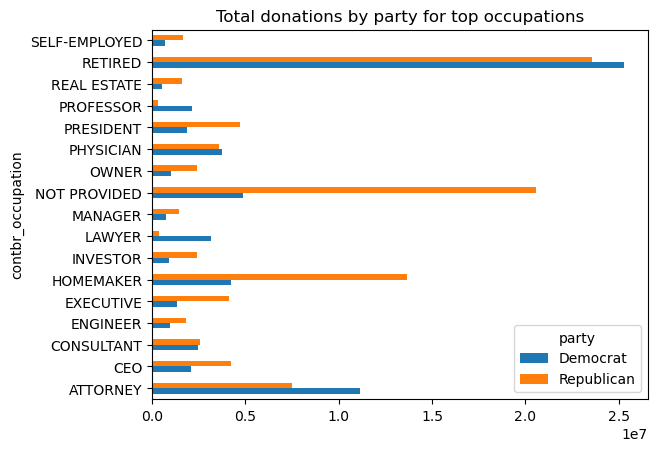

In [17]:
over_2mm.plot(kind="barh", title="Total donations by party for top occupations")

*You might be interested in the top donor occupations or top companies that donated to Obama and Romney. To do this, you can group by candidate name and use a variant of the `top` method from earlier in the chapter*

In [18]:
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)["contb_receipt_amt"].sum()
    return totals.nlargest(n)

grouped = fec_mrbo.groupby("cand_nm")
grouped.apply(get_top_amounts, "contbr_occupation", n=7)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [19]:
grouped.apply(get_top_amounts, "contbr_employer", n=10)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

## Bucketing Donation Amounts

*A useful way to analyze this data is to use the `cut` function to discretize the contributor amounts into buckets by contribution size*

In [20]:
bins = np.array([0, 1, 10, 100, 1000, 10000, 100_000, 1_000_000, 10_000_000])

labels = pd.cut(fec_mrbo["contb_receipt_amt"], bins)

labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [21]:
grouped = fec_mrbo.groupby(["cand_nm", labels])

grouped.size().unstack(level=0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


*Unstacking: .unstack(level=0) rearranges the data to have candidates as columns and bins as rows, providing a clear tabular view of the distribution of contribution amounts by candidate.*

*This data shows that Obama received a significantly larger number of small donations than Romney. You can also sum the contribution amounts and normalize within buckets to visualize the percentage of total donations of each size by candidate*

In [32]:
bucket_sums = grouped["contb_receipt_amt"].sum().unstack(level=0)

normed_sums = bucket_sums.div(bucket_sums.sum(axis="columns"), axis="index")

normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,0.000000
"(1000000, 10000000]",1.000000,0.000000


<Axes: title={'center': 'Percentage of total donations received by candidates for each donation size'}, ylabel='contb_receipt_amt'>

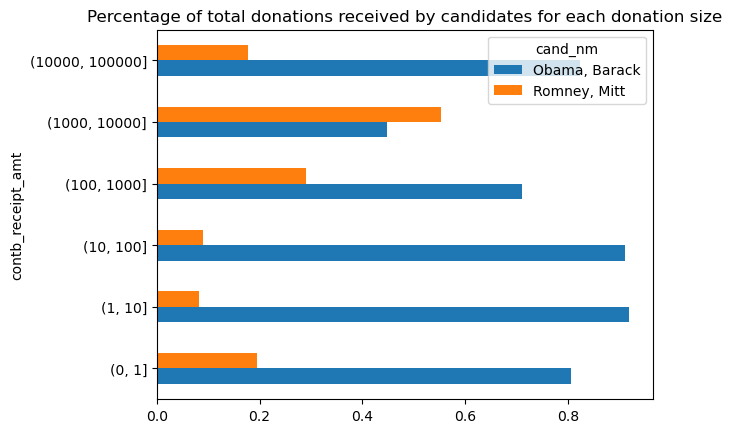

In [37]:
normed_sums[:-2].plot(kind="barh", title="Percentage of total donations received by candidates for each donation size")

*I excluded the two largest bins, as these are not donations by individuals.*

## Donation Statistics by State

*We can start by aggregating the data by candidate and state*

In [38]:
grouped = fec_mrbo.groupby(["cand_nm", "contbr_st"])

totals = grouped["contb_receipt_amt"].sum().unstack(level=0).fillna(0)

totals = totals[totals.sum(axis="columns") > 100000]

totals.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [39]:
percent = totals.div(totals.sum(axis="columns"), axis="index")

percent.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
